In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.stats import norm
from scipy.optimize import linprog

import warnings
from scipy.linalg import LinAlgWarning
from scipy.optimize import OptimizeWarning
warnings.filterwarnings(action='ignore', category=LinAlgWarning, module='scipy')
warnings.filterwarnings(action='ignore', category=OptimizeWarning, module='scipy')
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='scipy') # overflow warnings in multiply in linprog

In [2]:
import os
import pickle
from datetime import datetime

In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [4]:
from grid.policy import get_state, next_state, state_action_string, state_tuple
from grid.policy import get_policy, sample_policy, policy_noising, support, policy_data
from grid.policy import occupation_measure, occupation_measure_sanity
from grid.optimize import _sorted_risk_index as sorted_risk_index
from grid.optimize import _sorted_risk_dict as sorted_risk_dict
from grid.optimize import _min_risk as min_risk
from grid.optimize import _max_risk as max_risk
from grid.optimize import _pair_support as pair_support
from grid.params import _check_stochastic as check_stochastic
from grid.params import Rhigh, Rlow, Rbound
from grid.utils import sample_standard_simplex
from grid.plotting import plot_policy, plot_occupation_measure, plot_reward, plot_ratio

# Grid World

Consider an $m \times n$ board. Each tile of the board is a state. 

$$ \begin{array}{|c|c|c|}
\hline (0,0) & \cdots & (0,n-1) \\ \hline
\hline &  &  \\ \hline 
\hline (m-1,0) & \cdots & (m-1,n-1) \\
\hline
\end{array} $$

## Environment Parameters

In [5]:
m, n = 5, 5 # grid dimensions

In [6]:
actions = ['U','D','L','R','N']

In [7]:
states = [*range(m*n)]

In [8]:
delta = 0.05 # probability of moving randomly under each action

In [9]:
cost = 5.0 # cost of each cell (excluding obstacles)

In [10]:
epsilon = 0.01 # add Gaussian noise to reward and risk vectors 

In [11]:
discount = 0.95

In [12]:
final = get_state(m-1,n-1,m,n) # terminal state

In [13]:
init_state = get_state(0,0,m,n) # COMMENT OUT IF CHOSEN RANDOMLY
state_dist = np.eye(N=1,M=m*n,k=0).flatten() # COMMENT OUT IF CHOSEN RANDOMLY

In [14]:
T = 10*len(actions)*(m*n)**2 # time horizon, i.e., number of data points in dataset

## Obstacles

In [15]:
obstacle_num = 3

In [16]:
boundary = [i*n+j for i,j in zip([0]*n,list(range(n)))] + \
           [i*n+j for i,j in zip([m-1]*n,list(range(n)))] + \
           [i*n+j for i,j in zip(list(range(m)),[0]*m)] + \
           [i*n+j for i,j in zip(list(range(m)),[n-1]*m)]

boundary = [] # include boundary when choosing obstacles

In [17]:
# sample obstacles
states_excluded = list(set(states) - set([final,init_state]))
obstacles = []
while len(states_excluded)>0:
    obstacle = next_state(states_excluded)[0]
    states_excluded = list(set(states_excluded)-set([obstacle]))
    obstacles.append(obstacle)
    if len(obstacles)==obstacle_num:
        break        

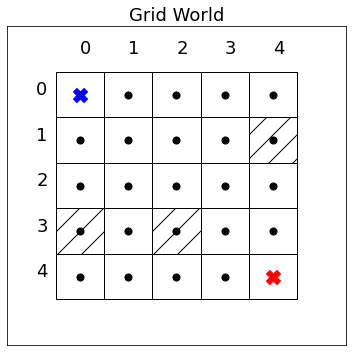

In [18]:
plot_policy({},states,actions,m,n,init_state,final,obstacles=obstacles,title='Grid World',title_fontsize=18, cell_unit_length=1.0)

In [19]:
tol = 1e-8 # tolerance for near 0 results

In [20]:
sensitivity = 1e-5 # sensitivity to improvement towards optimal value

## Actions

Actions are $\mathcal{A} = \{U,D,L,R,N\}$ correspond to moving *up*, *down*, *left*, *right*, or *none* for staying put. 

If possible, we move accordingly with probability $1-\delta$ under action $a=U,D,L,R$. There is a small transition probability $\delta$ to all other states.

For $a \in \mathcal{A}$, the transition matrix $P(a) \in {M}_{\vert \mathcal{S} \vert}(\mathbb{R})$ is
$$\begin{align*}
    & P(a)_{s',s} = \Pr[s' \vert s,a]
\end{align*}$$

i.e., the probability of transitioning from $s$ to $s'$ under action $a$. 

In [21]:
PU = delta/(m*n-1) * np.ones(shape=(m*n,m*n)) 

for i in range(m): # rows
    for j in range(n): # cols
        if i==0:
                PU[i*n+j,i*n+j] = 1 - delta            
        else:
                PU[(i-1)*n+j,i*n+j] = 1 - delta                    

In [22]:
PD = delta/(m*n-1)*np.ones(shape=(m*n,m*n)) 

for i in range(m): # rows
    for j in range(n): # cols
        if i==m-1:
            PD[i*n+j,i*n+j] = 1 - delta            
        else:
            PD[(i+1)*n+j,i*n+j] = 1 - delta                    

In [23]:
PL = delta/(m*n-1)*np.ones(shape=(m*n,m*n))

for i in range(m): # rows
    for j in range(n): # cols
        if j==0:
            PL[i*n+j,i*n+j] = 1 - delta            
        else:
            PL[i*n+(j-1),i*n+j] = 1 - delta                    

In [24]:
PR = delta/(m*n-1)*np.ones(shape=(m*n,m*n)) 

for i in range(m): # rows
    for j in range(n): # cols
        if j==n-1:
            PR[i*n+j,i*n+j] = 1 - delta            
        else:
            PR[i*n+(j+1),i*n+j] = 1 - delta                                        

In [25]:
deltaN = 0.5

PN = deltaN/(m*n-1)*np.ones(shape=(m*n,m*n))

for i in range(m): # rows
    for j in range(n): # cols
        PN[i*n+j,i*n+j] = 1 - deltaN

In [26]:
check_stochastic(PU)
check_stochastic(PD)
check_stochastic(PL)
check_stochastic(PR)
check_stochastic(PN)

## Reward

Consider $c \in \mathbb{R}^{\vert S \vert}$ and define the expected reward vector $r \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ to be

$$\begin{align*}
    & r(s,a) = \sum_{s' \in \mathcal{S}} c_{s'} P(a)_{s',s} 
\end{align*}$$

Pick some grid state $s_f$ as the final destination. Let $c_{s_f} = 0$ and $c_{s} = -1$ for $s \neq s_f$. Maximizing the reward would then imply reaching the destination by the shortest route. 

We can add a set of obstacles $\mathcal{S}_O \subseteq \mathcal{S}$ to the grid by setting $c_s = M \ll -1$ for $s \in \mathcal{S}_O$.

In __[Chow et al, NIPS '15](https://proceedings.neurips.cc/paper/2015/hash/64223ccf70bbb65a3a4aceac37e21016-Abstract.html)__ one has $M = {2}/{(1-\gamma)}$ for a discount factor $\gamma$.


In [27]:
M = 2/(1-discount) # obstacle penalty -1 

In [28]:
print('Obstacle penalty: {:.3f}'.format(M))

Obstacle penalty: 40.000


In [29]:
c = -cost*np.ones(m*n)[:,None] # negative cost

c[final] = 0.0
for o in obstacles:
    c[o] = -M

P = np.hstack([PU,PD,PL,PR,PN])
r = (c.T @ P).T # reward vector

We will add some jitter to the reward vector to ensure non-degeneracy.

In [30]:
r = r + norm(loc=0, scale=epsilon).rvs(r.shape)
r = np.where(r>0,0,r)

## Risk

We'll define a risk vector $d \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ weighed against moving along the upper or lower edges of the board (this will ensure no cell is degenerate).

We will also add a bit of additional risk for doing nothing.

There is a non-zero lower bound on risk to avoid "exploding" ratio for epsilon risks.

In [31]:
UR = Rbound*np.ones(m*n)[:,None]
DR = Rbound*np.ones(m*n)[:,None]
LR = Rbound*np.ones(m*n)[:,None]
RR = Rbound*np.ones(m*n)[:,None]
NR = Rlow*np.ones(m*n)[:,None]

for i in range(m):

    LR[n*i] = Rlow # walk into left boundary
    RR[n*i+(n-1)] = Rlow # walk into right boundary
    
for j in range(n):
    
    UR[j] = Rlow # walk into upper boundary
    DR[n*(m-1)+j] = Rlow # walk into lower boundary
        
    if j>0:
        LR[j] = Rhigh # walk along upper boundary
        LR[n*(m-1)+j] = Rhigh # walk along lower boundary
    
    if j<n-1:
        RR[j] = Rhigh # walk along upper boundary
        RR[n*(m-1)+j] = Rhigh # walk along lower boundary

In [32]:
d = np.vstack([UR,DR,LR,RR,NR]) # risk vector

We will add some jitter to the reward vector to ensure non-degeneracy.

In [33]:
d = d + norm(loc=0, scale=epsilon).rvs(d.shape)

d = -np.where(d<0,Rbound,d)

Create two risk vectors.

In [34]:
k = 2 # number of risks

In [35]:
mask = np.pad(np.ones(len(states)), (0, d.size-len(states)), 'constant', constant_values=(0, 0))

In [36]:
d1 = d*mask[:,None]

In [37]:
d2 = d-d1

## Optimal Policy

The optimal policy for the EMRDP (with $\omega = 1$), phrased in terms of the occupancy measure $\rho^\pi \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ of $\pi$, is formulated in this case as

$$\min_{\pi} \bigg\{ \frac{r^T \rho^\pi}{d^T \rho^\pi} \,\bigg| \, Q\rho^\pi=\mu, \rho^\pi \geq 0 \bigg\} $$

In the discounted model, 
$$\begin{align*}
    Q = \bigg[ I-\gamma P(a_1) \, \bigg| \,\cdots\, \bigg|\, I - \gamma P(a_k) \bigg] , \quad
\end{align*}$$

for $\mathcal{A} = \{a_1,\ldots,a_k\}$, and $\mu$ is some initial state distribution.

In [38]:
I = np.identity(m*n)

Q = np.hstack([I-discount*PU,I-discount*PD,I-discount*PL,I-discount*PR,I-discount*PN])

The row vector $(1,\ldots,1) \in \mathbb{R}^{\vert \mathcal{S} \vert}$ is an eigenvector of $Q$ for the  eigenvalue $(1-\gamma)$.

In [39]:
np.ones((1,Q.shape[0])) @ Q / (1-discount)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

## Run Optimization: Single Step

Run algorithm for finding the optimal policy manually, step by step.

In [40]:
def calc_risk(ds,rho,omega):
    return -np.power(np.abs(ds@rho),omega).sum()

In [41]:
def calc_reward(r,rho):
    return (r.T@rho)[0]

In [42]:
def get_current_rho(front: list, ds: np.array, omega: np.array) -> np.array:    
    return front[np.argmin(np.array([calc_risk(ds,rho,omega) for rho in front]))]

In [43]:
def get_front_reward(front: list, r: np.array):    
    return np.array([(r.T@rho)[0] for rho in front]).max()

In [44]:
def true_in_indices(N: int, indices) -> np.array:
    j = np.zeros(N).astype(bool)
    for idx in indices:
        j += np.eye(1,state_action_num,idx).flatten().astype(bool)    
    return j

In [45]:
def unique_policies(rhos: list) -> np.ndarray:
    _, uidx = np.unique(np.vstack([support(rho)[None,:] for rho in rhos]),axis=0,return_index=True)
    return np.vstack(rhos)[uidx]

Problem input.

In [46]:
state_num = len(states)
action_num = len(actions)
state_action_num = state_num*action_num
sas = np.ones(state_num*action_num)

A = np.vstack([Q,d1.T,d2.T])
mu = state_dist
ds = np.vstack([d1.T,d2.T])

omega = np.array([1.0,1.0])

Initialize.

In [47]:
rho_min = min_risk(Q,state_dist,discount,d,tol) # decrease numerical sensitivity for min

front = [rho_min]
rhos = []

stop = False

Running the next cell repeatedly, will manually produce the next policy on the Pareto front.

In [48]:
verbose = False

In [49]:
T = np.inf

In [50]:
from itertools import combinations

report = {}
itr = 0

while not stop:
    
    top_found = 0
    itr += 1        
    report[itr] = {}

    if verbose:
        print(f'---------------------------------------------------------')
        print(f'Iteration: {itr} (of {T})')        
        print(f'Policies in front: {len(front)}')
    
    rho_current = get_current_rho(front, ds, omega) # policy of minimal risk along front
    rho_risk = calc_risk(ds,rho_current,omega)
    rho_reward = (r.T@rho_current)[0]    
    front_reward = get_front_reward(front,r)

    if verbose:
        print(f'Current reward={rho_reward:.5f}, risk={rho_risk:.5f}, ratio={rho_reward/rho_risk:.5f}')

    supp = support(rho_current)
    assert supp.sum() == len(states) # current policy is deterministic
    sas_current = sas*(~supp)

    for include in combinations(np.nonzero(sas_current)[0], k):

        j = true_in_indices(state_action_num,include)
        I = supp + j
        
        try:
  
            AIinv = la.inv(A[:,I])
            B = (r.T[:,I]@AIinv)@A - r.T
            B[np.isclose(B,0.0,atol=tol)] = 0.0

            if np.all(B >= 0.0): # condition for top dim'l simplex in triangulation 

                top_found += 1

                J = np.array([*range(A.shape[-1])])[(~(B > 0)).flatten()] # should be = I
                assert (J==np.nonzero(I)[0]).all(), 'J!=I'
                AJinv = la.inv(A[:,J])

                Jrhos = []

                for exclude in combinations(J, k):

                    e = true_in_indices(state_action_num,exclude)

                    if (j & e).sum() == k-1: # exclude supp 

                        Isub = I & ~e # face
                        assert Isub.sum()==state_num, 'IsubNotDeterministic'
                        Jsub = np.nonzero(Isub)[0]

                        try:                    
                            rho_nextJsub = la.solve(Q[:,Jsub],(1-discount)*mu)
                            rho_nextJsub = np.where(np.isclose(rho_nextJsub,0.0,atol=tol),0.0,rho_nextJsub)
                        except:
                            rho_nextJsub = -np.ones(A.shape[-1]) # no intersection of face hyperplane with H

                        if np.all(rho_nextJsub>=0.0): # intersection with H inside Cone(A_{Jsub})
                            rho_next = np.zeros(A.shape[-1])
                            rho_next[Jsub] = rho_nextJsub
                            assert np.allclose((A@rho_next)[:-k],(1-discount)*mu,atol=tol), 'NextRhoNotSolution'
                            assert np.isclose(rho_next.sum(),1.0,atol=tol), 'NextRhoNotMeasure'
                            Jrhos.append(rho_next)


                if all([calc_risk(ds,rho,omega)>=rho_risk for rho in Jrhos]):
                    front += Jrhos
                    
        except AssertionError as e:
            
            report[itr]['type'] = e
            if e=='J!=I':
                report[itr]['values'] = {'I': I, 'J': J, 'B': B}
            continue            
            
        except:

            report[itr]['type'] = 'MatrixInversionFail'
            report[itr]['values'] = {'supp': supp, 'j': j, 'I': I}
            continue

    if verbose:
        print(f'Top simplices found for current rho: {top_found}')
        
    front_arr = unique_policies(front)
    front = [rho for rho in front_arr if not np.allclose(rho,rho_current,atol=tol)] # remove current rho from front    
    rhos.append(rho_current)    
    stop = (len(front)==0) or (get_front_reward(front,r) < front_reward) or (itr >= T) # use convexity of reward    
 
    if verbose:
        print('---------------------------------------------------------')
    
    

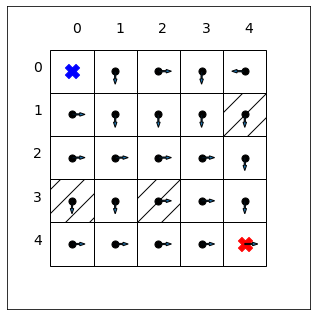

In [51]:
policy = get_policy(np.around(rho_current,4), states, actions)
plot_policy(policy,states,actions,m,n,init_state,final,obstacles=obstacles,cell_unit_length=0.9)

In [52]:
policies = [get_policy(rho, states, actions) for rho in front]
# plot_policy(policies,states,actions,m,n,init_state,final,obstacles=obstacles,cell_unit_length=0.8,ncols=4)

In [53]:
# %reload_ext autoreload

# from grid.policy import occupation_measure_sanity

# sanity check: all rhos are occupation measures
for i,rho in enumerate(rhos):
    occupation_measure_sanity(rho,A,state_dist,discount,report={},tol=tol*100,k=k)

## Results

Plot algorithm results for finding the true optimal policy.

In [54]:
rewards = np.apply_along_axis(lambda rho: calc_reward(r,rho),axis=1,arr=rhos)

In [55]:
risks = np.apply_along_axis(lambda rho: calc_risk(ds,rho,omega),axis=1,arr=rhos)

In [56]:
# for i, (re, ri) in enumerate(zip(rewards, risks)):
#     print('Iteration {}: reward {:.3f}, risk {:.3f}, ratio: {:.3f}'.format(i,(re),ri,(re)/(ri)))

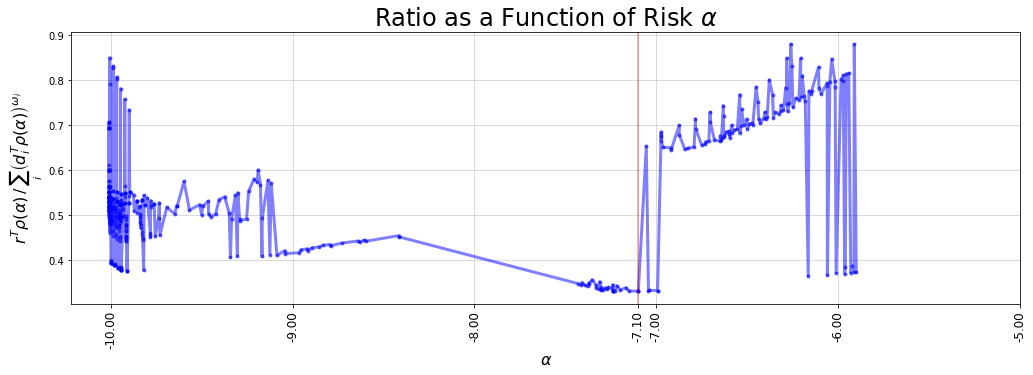

In [57]:
# %reload_ext autoreload

# from grid.plotting import plot_ratio

if len(rewards)>1:
    plot_ratio(risks, rewards, atol=2, set_ticks=False, mark_min=True, ylabel_weighted=True, figsize=(17,5), titlefontsize=24)

In [58]:
argmin=0

for i, (re, ri) in enumerate(zip(rewards, risks)):
    # print('Iteration {}: reward {:.3f}, risk {:.3f}, ratio: {:.3f}'.format(i,(re),ri,(re)/(ri)))
    argmin = i if (re)/(ri) < rewards[argmin]/risks[argmin] else argmin

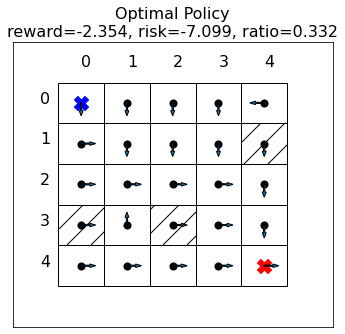

In [59]:
multi_p = get_policy(np.around(rhos[argmin],4), states, actions)

title = 'Optimal Policy\nreward={:.3f}, risk={:.3f}, ratio={:.3f}'.format(rewards[argmin],risks[argmin],rewards[argmin]/risks[argmin])
plot_policy(multi_p,states,actions,m,n,init_state,final,obstacles=obstacles,cell_unit_length=0.95,title=title,title_fontsize=16)

## Run Optimization: End to End

In [60]:
from grid.optimize import optimal_policy

In [61]:
fun_rhos, fun_rewards, fun_risks, fun_success = \
    optimal_policy(
        states,actions,Q,r,d,state_dist,discount,sensitivity=sensitivity,tol=tol,is_verbose=False
)

In [62]:
print(f'Theoretical optimum found with confidence: {fun_success}')

Theoretical optimum found with confidence: True


In [63]:
argmin=0

for i, (re, ri) in enumerate(zip(fun_rewards, fun_risks)):
    # print('Iteration {}: reward {:.3f}, risk {:.3f}, ratio: {:.3f}'.format(i,(re),ri,(re)/(ri)))
    argmin = i if (re)/(ri) < fun_rewards[argmin]/fun_risks[argmin] else argmin

In [64]:
fun_rewards_argmax = np.argmax(np.array(fun_rewards))

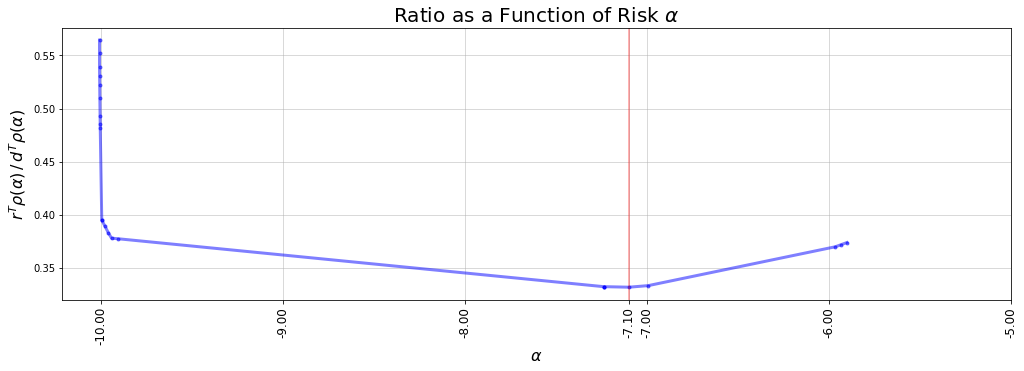

In [65]:
# plot pareto for ratio
plot_ratio(fun_risks[:fun_rewards_argmax+1], fun_rewards[:fun_rewards_argmax+1], atol=2, set_ticks=False, mark_min=True, figsize=(17,5))

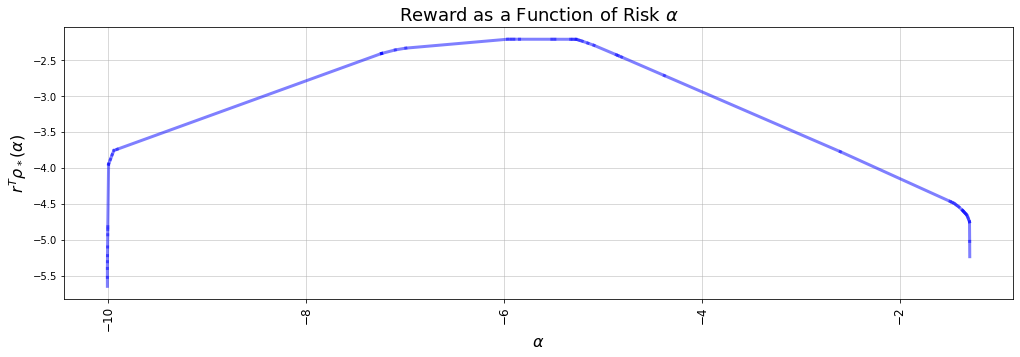

In [66]:
# %reload_ext autoreload

# from grid.policy import occupation_measure_sanity

# plot pareto for reward
plot_reward(fun_risks, fun_rewards, atol=2, figsize=(17,5), set_ticks=False)

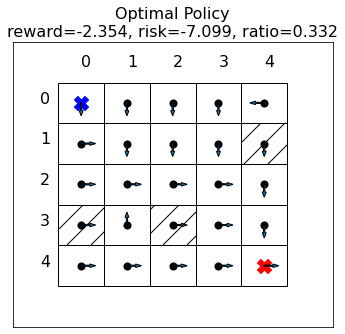

In [67]:
fun_p = get_policy(np.around(fun_rhos[argmin],4), states, actions)

title = 'Optimal Policy\nreward={:.3f}, risk={:.3f}, ratio={:.3f}'.format(fun_rewards[argmin],fun_risks[argmin],fun_rewards[argmin]/fun_risks[argmin])
plot_policy(fun_p,states,actions,m,n,init_state,final,obstacles=obstacles,cell_unit_length=0.95,title=title,title_fontsize=16)

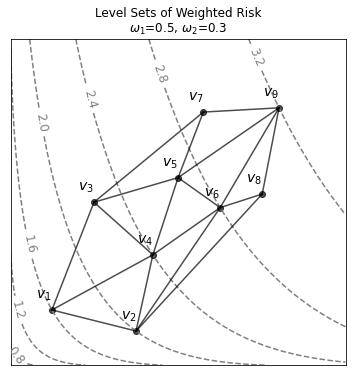

In [68]:
omegas = [0.5,0.3]
delta = 0.01
alpha = 0.7
x = np.arange(0.01, 4.0, delta)
y = np.arange(0.01, 4.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.power(X,omegas[0])
Z2 = np.power(Y,omegas[1])
Z = (Z1 + Z2)

fig, ax = plt.subplots(figsize=(6,6))
CS = ax.contour(X, Y, Z, linestyles='dashed', colors='grey')
vertices = np.array([
    [0.5,np.power(1.6-np.sqrt(0.5),10/3)],
    [1.0,2.0],
    [1.5,np.power(2.0-np.sqrt(1.5),10/3)],
    [1.7,np.power(2.4-np.sqrt(1.7),10/3)],
    [2.5,np.power(2.8-np.sqrt(2.5),10/3)],
    [3.0,2.1],
    [3.2,np.power(3.2-np.sqrt(3.2),10/3)],
    [2.0,2.3],
    [2.3,3.1]
])
labels = ['$v_1$','$v_3$','$v_2$','$v_4$','$v_6$','$v_8$','$v_9$','$v_5$','$v_7$']
manual_locations = [
    (0.1,0.15),
    (0.15,0.7),
    (0.3,1.5),
    (0.5,3.0),
    (1.1,3.3),
    (1.6,3.5),
    (3.0,3.8)
]
ax.clabel(CS, inline=True, fontsize=12, manual=manual_locations)
slices = [[0,1],[0,2],[0,3],[1,3], [2,3], [2,4], [3,4], [2,5], [4,5], [4,6], [4,7], [5,6], [1,7], [3,7], [1,8], [6,8], [6,7], [7,8]]
for sl in slices:
    ax.plot(vertices[sl,0],vertices[sl,1],c='black', alpha=alpha)
ax.scatter(vertices[:,0],vertices[:,1],c='black', alpha=alpha)

for x,y,l in zip(vertices[:,0],vertices[:,1],labels):
    plt.annotate(l, # this is the value which we want to label (text)
                 (x,y), # x and y is the points location where we have to label
                 textcoords="offset points",
                 xytext=(0,7), # this for the distance between the points
                 va='bottom',
                 ha='right',
                 fontsize=14)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_title(f'Level Sets of Weighted Risk\n$\omega_1$={omegas[0]}, $\omega_2$={omegas[1]}');